# Regresión Lineal

## Preparación de ambiente

### Carga de módulos

In [61]:
# Data Wrangling
import numpy as np
import pandas as pd

# Data View
from typing import Optional
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Data Viz
import plotly.express as px
#import cufflinks as cf

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

# Model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error




In [62]:

def estandarizar_df(df):
   
    df_estandarizado = df.copy()
    
    # 1. Limpiar nombres de columnas
    def limpiar_nombre(nombre, indice):
        nombre = str(nombre).strip()
        nombre = ' '.join(nombre.split())
        nombre = nombre.upper().replace(' ', '_')
        
        # Filtrar solo caracteres válidos
        nombre_limpio = ''.join(char for char in nombre if char.isalnum() or char == '_')
        
        if not nombre_limpio:
            nombre_limpio = f'COLUMNA_{indice+1}'
        
        return nombre_limpio
    
    # Crear nuevos nombres evitando duplicados
    nombres_nuevos = []
    nombres_vistos = set()
    
    for i, col in enumerate(df_estandarizado.columns):
        nombre_base = limpiar_nombre(col, i)
        nombre_final = nombre_base
        contador = 1
        
        while nombre_final in nombres_vistos:
            nombre_final = f"{nombre_base}_{contador}"
            contador += 1
        
        nombres_nuevos.append(nombre_final)
        nombres_vistos.add(nombre_final)
    
    df_estandarizado.columns = nombres_nuevos
    
    # 2. Procesar datos de cada columna
    for columna in df_estandarizado.columns:
        # Para columnas de tipo objeto (strings o mixtas)
        if df_estandarizado[columna].dtype == 'object':
            try:
                # Intentar convertir a numérico
                serie_numerica = pd.to_numeric(df_estandarizado[columna], errors='coerce')
                
                # Si se pudo convertir algún valor (no todos son NaN)
                if serie_numerica.notna().any():
                    # Mantener el tipo numérico para los convertibles
                    df_estandarizado[columna] = serie_numerica
                else:
                    # Si no hay valores numéricos, convertir strings a mayúsculas
                    df_estandarizado[columna] = df_estandarizado[columna].apply(
                        lambda x: x.upper() if isinstance(x, str) else x
                    )
            except:
                # Si hay error, solo convertir strings a mayúsculas
                df_estandarizado[columna] = df_estandarizado[columna].apply(
                    lambda x: x.upper() if isinstance(x, str) else x
                )
    
    return df_estandarizado



def completitud_datos(df: pd.DataFrame) -> pd.Series:    
    """
    Calcula el porcentaje de completitud de datos para DataFrames de Pandas.
    
    Esta función analiza cada columna del DataFrame y calcula el porcentaje de 
    valores nulos presentes, ordenados de mayor a menor porcentaje de nulos.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas a analizar.
        
    Returns
    -------
    pd.Series
        Serie de pandas con los nombres de las columnas como índice
        y los porcentajes de valores nulos (entre 0.0 y 1.0) como valores,
        ordenados de mayor a menor porcentaje de nulos.
        
    """
    return round(df.isnull().sum().sort_values(ascending=False) / df.shape[0], 4)

def impute_missing_values(df: pd.DataFrame, method: str = 'auto') -> pd.DataFrame:
    """
    Imputa valores faltantes usando diferentes métodos según el tipo de variable.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas con valores faltantes a imputar.
    method : str, default 'auto'
        Método de imputación a utilizar. Opciones:
        - 'auto': media para numéricas, moda para categóricas
        - 'mean': media para variables numéricas
        - 'median': mediana para variables numéricas
        - 'knn': K-Nearest Neighbors para numéricas, moda para categóricas
        
    Returns
    -------
    pd.DataFrame
        DataFrame con valores faltantes imputados.
        
    Raises
    ------
    ValueError
        Si el método especificado no es reconocido.
        
    Notes
    -----
    La función imprime información sobre el proceso de imputación para cada columna,
    incluyendo el método utilizado y los valores de relleno aplicados.
    """
    df = df.copy()
    print(f"Valores faltantes antes de imputar:\n{df.isnull().sum().sum()} en total")
    
    if method == 'knn':
        # Separar columnas numéricas y categóricas
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        
        df_result = df.copy()
        
        # Primero imputar columnas categóricas con moda
        for col in categorical_cols:
            if df_result[col].isnull().sum() > 0:
                mode_value = df_result[col].mode()
                if not mode_value.empty:
                    fill_value = mode_value.iloc[0]
                else:
                    fill_value = 'Unknown'
                df_result[col].fillna(fill_value, inplace=True)
                print(f"Columna categórica '{col}': imputada con moda '{fill_value}'")
        
        # Luego aplicar KNN solo a columnas numéricas
        if len(numeric_cols) > 0 and df_result[numeric_cols].isnull().sum().sum() > 0:
            knn_imputer = KNNImputer(n_neighbors=5)
            numeric_data_imputed = knn_imputer.fit_transform(df_result[numeric_cols])
            df_result[numeric_cols] = pd.DataFrame(numeric_data_imputed, 
                                                  columns=numeric_cols, 
                                                  index=df_result.index)
            print(f"Columnas numéricas: imputadas con KNN")
        
        return df_result
    
    else:
        # Método automático o específico
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if df[col].dtype in ['object', 'category']:
                    # Variables categóricas: usar moda
                    mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
                    df[col].fillna(mode_value, inplace=True)
                    print(f"Columna '{col}' (categórica): imputada con moda '{mode_value}'")
                
                else:
                    # Variables numéricas
                    if method == 'mean' or method == 'auto':
                        fill_value = df[col].mean()
                        method_name = 'media'
                    elif method == 'median':
                        fill_value = df[col].median()
                        method_name = 'mediana'
                    else:
                        raise ValueError("Método no reconocido. Use 'auto', 'mean', 'median' o 'knn'.")
                    
                    df[col].fillna(fill_value, inplace=True)
                    print(f"Columna '{col}' (numérica): imputada con {method_name} ({fill_value:.2f})")
    
    print(f"\nValores faltantes después de imputar: {df.isnull().sum().sum()}")
    return df

def detect_outliers_zscore(df: pd.DataFrame, columns: list = None, threshold: float = 3.0) -> pd.DataFrame:
    """
    Detecta outliers usando el método Z-Score.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas a analizar.
    columns : list, optional
        Lista de nombres de columnas a analizar. Si es None, analiza todas las columnas numéricas.
    threshold : float, default 3.0
        Umbral del z-score. Valores con |z-score| > threshold se consideran outliers.
        
    Returns
    -------
    pd.DataFrame
        DataFrame con información detallada sobre outliers por columna, incluyendo:
        - Media y desviación estándar
        - Umbral utilizado
        - Número y porcentaje de outliers
        
    Notes
    -----
    El método Z-Score identifica outliers basándose en cuántas desviaciones estándar
    se aleja un valor de la media. Se asume que los datos siguen una distribución normal.
    """
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    outlier_info = []
    
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outliers = df[z_scores > threshold]
        
        outlier_info.append({
            'columna': col,
            'media': df[col].mean(),
            'std': df[col].std(),
            'threshold': threshold,
            'num_outliers': len(outliers),
            'porcentaje_outliers': (len(outliers) / len(df)) * 100
        })
    
    return pd.DataFrame(outlier_info)


def remove_outliers(df: pd.DataFrame, method: str = 'iqr', columns: list = None, **kwargs) -> pd.DataFrame:
    """
    Elimina outliers del DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas del cual eliminar outliers.
    method : str, default 'iqr'
        Método a usar para detectar outliers ('iqr' o 'zscore').
    columns : list, optional
        Lista de columnas a considerar para la detección de outliers.
        Si es None, considera todas las columnas numéricas.
    **kwargs : dict
        Argumentos adicionales para los métodos de detección:
        - Para 'iqr': 'factor' (default 1.5)
        - Para 'zscore': 'threshold' (default 3.0)
        
    Returns
    -------
    pd.DataFrame
        DataFrame sin los outliers detectados.
        
    Notes
    -----
    La función imprime estadísticas sobre el proceso de eliminación,
    incluyendo el número de filas eliminadas y el porcentaje del total.
    """
    df_clean = df.copy()
    
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    initial_rows = len(df_clean)
    
    if method == 'iqr':
        factor = kwargs.get('factor', 1.5)
        for col in columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    elif method == 'zscore':
        print("Eliminando outliers usando el método Z-Score. threshold ")
        threshold = kwargs.get('threshold', 3.0)
        print(f"Eliminando outliers usando el método Z-Score. threshold {threshold}")   
        for col in columns:
            z_scores = np.abs((df_clean[col] - df_clean[col].mean()) / df_clean[col].std())
            df_clean = df_clean[z_scores <= threshold]
    
    final_rows = len(df_clean)
    removed_rows = initial_rows - final_rows
    
    print(f"Filas originales: {initial_rows}")
    print(f"Filas eliminadas: {removed_rows}")
    print(f"Filas restantes: {final_rows}")
    print(f"Porcentaje eliminado: {(removed_rows/initial_rows)*100:.2f}%")
    
    return df_clean

In [63]:
## Visualización de datos

def plot_interactive_boxplot(df: pd.DataFrame, column: str, group_by: Optional[str] = None,
                            target_class: Optional[str] = None, title: Optional[str] = None,
                            save_plot: bool = True):
    """
    Boxplot interactivo con subgráficos por clase objetivo.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas con los datos a graficar.
    column : str
        Nombre de la columna numérica a graficar.
    group_by : Optional[str], default None
        Nombre de la columna para agrupar los datos.
    target_class : Optional[str], default None
        Nombre de la columna de clase objetivo para crear subgráficos.
    title : Optional[str], default None
        Título personalizado para el gráfico.
    save_plot : bool, default True
        Si guardar automáticamente el gráfico en la carpeta plots/.
        
    Returns
    -------
    plotly.graph_objects.Figure
        Figura interactiva de Plotly con el boxplot.
    """
    if title is None:
        title = f'Boxplot de {column}'
    
    if target_class is not None:
        # Crear subgráficos por clase objetivo
        unique_classes = df[target_class].unique()
        fig = make_subplots(rows=1, cols=len(unique_classes),
                           subplot_titles=[f'{target_class}: {cls}' for cls in unique_classes])
        
        for i, cls in enumerate(unique_classes, 1):
            subset = df[df[target_class] == cls]
            
            if group_by is not None:
                for group in subset[group_by].unique():
                    group_data = subset[subset[group_by] == group][column]
                    fig.add_trace(go.Box(y=group_data, name=f'{group}', 
                                       boxpoints='outliers', showlegend=(i==1)),
                                 row=1, col=i)
            else:
                fig.add_trace(go.Box(y=subset[column], name=f'{cls}',
                                   boxpoints='outliers', showlegend=False),
                             row=1, col=i)
        
        fig.update_layout(title=title, height=500)
    else:
        # Boxplot simple o agrupado
        if group_by is not None:
            fig = px.box(df, y=column, x=group_by, title=title, points='outliers')
        else:
            fig = px.box(df, y=column, title=title, points='outliers')
    
    return fig

## 1. Data Wrangling

### 1.1 Lectura de datos

In [64]:
df = pd.read_excel("Team calor o team frío.xlsx")

print(type(df))

<class 'pandas.core.frame.DataFrame'>


### 1.2 Exploracion de datos

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 15 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Marca temporal                                       207 non-null    object
 1   Color primario favorito                              207 non-null    object
 2   Edad en años (numérica)                              207 non-null    object
 3   Estatura en metros (numérica)                        207 non-null    object
 4   Peso en kg (numérica)                                195 non-null    object
 5   Tipo de personalidad                                 207 non-null    object
 6   Número de vasos de agua que tomas al día (numérico)  207 non-null    object
 7   ¿Día o noche?                                        207 non-null    object
 8   Actividad física                                     207 non-null    object
 9  

In [66]:
df.sample(5)

,Marca temporal,Color primario favorito,Edad en años (numérica),Estatura en metros (numérica),Peso en kg (numérica),Tipo de personalidad,Número de vasos de agua que tomas al día (numérico),¿Día o noche?,Actividad física,Mascota favorita,¿Chile del que pica o del que no pica?,Número de hermanos (numérica),¿Las quesadillas van con queso?,Número de tatuajes (numérica),¿Team frío o team calor?
185,2026-01-08 18:09:05.571000,Granate,32,1.5,53,Introvertido,8,Noche,Si,Perros,Del que no pica,3,Sin queso,0,Team frío
40,2024-03-21 16:02:08.364000,Rojo,21,1.6,63,Extrovertido,2,Noche,Si,Perrro,Del que pica,2,Con queso,0,Team frío
147,2024-09-26 18:57:02.342000,Rojo,24,1.58,54,Introvertido,8,Noche,Si,Gato,Del que pica,2,Con queso,0,Team frío
69,2024-03-21 16:48:08.615000,Rojo,21,1.6,63,Introvertido,5,Noche,Si,Gato,Del que no pica,3,Con queso,0,Team frío
6,2024-03-16 10:04:57.001000,Azul,38,1.76,85,Introvertido,4,Noche,¿Qué es eso?,Gato,Del que pica,4,Sin queso,0,NaN


Se obervan varios datos con mayusulas y minusculas, se realizará una estandarización a mayusculas pera tener una mejor visuzalización.

In [67]:
df = estandarizar_df(df)
df.sample(5)

,MARCA_TEMPORAL,COLOR_PRIMARIO_FAVORITO,EDAD_EN_AÑOS_NUMÉRICA,ESTATURA_EN_METROS_NUMÉRICA,PESO_EN_KG_NUMÉRICA,TIPO_DE_PERSONALIDAD,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,DÍA_O_NOCHE,ACTIVIDAD_FÍSICA,MASCOTA_FAVORITA,CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA,NÚMERO_DE_HERMANOS_NUMÉRICA,LAS_QUESADILLAS_VAN_CON_QUESO,NÚMERO_DE_TATUAJES_NUMÉRICA,TEAM_FRÍO_O_TEAM_CALOR
19,2024-03-16 10:06:43.073000,AZUL,31.0,1.80,90.0,EXTROVERTIDO,12.0,DÍA,SI,PERRRO,DEL QUE NO PICA,1.0,CON QUESO,0.0,TEAM FRÍO
158,26/6/2025 18:10:58,AZUL,22.0,1.68,61.0,EXTROVERTIDO,5.0,DIA,SI,PERRO,DEL QUE PICA,2.0,SIN QUESO,4.0,TEAM FRÍO
159,26/6/2025 18:11:07,AZUL,28.0,160.00,80.0,INTROVERTIDO,8.0,NOCHE,SI,GATO,DEL QUE PICA,3.0,SIN QUESO,6.0,TEAM FRÍO
202,2026-01-08 18:17:46.615000,LILA,24.0,1.60,52.0,EXTROVERTIDO,6.0,DIA,SI,PERRO,DEL QUE NO PICA,1.0,CON QUESO,0.0,TEAM FRÍO
1,2024-03-16 10:04:42.278000,AZUL,26.0,1.57,58.0,INTROVERTIDO,5.0,NOCHE,¿QUÉ ES ESO?,PERRRO,DEL QUE PICA,0.0,CON QUESO,0.0,NaN


Se obervan datos vacios en varias columnas. Se procede a analizar la completitud de los datos.

In [68]:
completitud_datos(df) 

PESO_EN_KG_NUMÉRICA                                  0.0821
TEAM_FRÍO_O_TEAM_CALOR                               0.0676
ESTATURA_EN_METROS_NUMÉRICA                          0.0145
NÚMERO_DE_TATUAJES_NUMÉRICA                          0.0145
NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO    0.0145
NÚMERO_DE_HERMANOS_NUMÉRICA                          0.0097
EDAD_EN_AÑOS_NUMÉRICA                                0.0048
MASCOTA_FAVORITA                                     0.0048
TIPO_DE_PERSONALIDAD                                 0.0000
MARCA_TEMPORAL                                       0.0000
COLOR_PRIMARIO_FAVORITO                              0.0000
CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA                 0.0000
ACTIVIDAD_FÍSICA                                     0.0000
DÍA_O_NOCHE                                          0.0000
LAS_QUESADILLAS_VAN_CON_QUESO                        0.0000
dtype: float64

Se oberva lo siguiente:
1. `PERRO` esta escrito con diferentes `R` por lo que se va a corregir.
2.  Ausencia de datos de aproximadamente 5% en algunas variables

In [69]:
# Reemplazar variaciones de PERRO con múltiples R por PERRO
df["MASCOTA_FAVORITA"] = df["MASCOTA_FAVORITA"].str.replace(r'PER+RO', 'PERRO', regex=True)
df["MASCOTA_FAVORITA"] = df["MASCOTA_FAVORITA"].str.replace(r'PERROS', 'PERRO', regex=True)

df["MASCOTA_FAVORITA"] = df["MASCOTA_FAVORITA"].str.replace(r'PER+RO', 'PERRO', regex=True)
df["MASCOTA_FAVORITA"] = df["MASCOTA_FAVORITA"].str.replace(r'GATOS', 'GATO', regex=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   MARCA_TEMPORAL                                     207 non-null    object 
 1   COLOR_PRIMARIO_FAVORITO                            207 non-null    object 
 2   EDAD_EN_AÑOS_NUMÉRICA                              206 non-null    float64
 3   ESTATURA_EN_METROS_NUMÉRICA                        204 non-null    float64
 4   PESO_EN_KG_NUMÉRICA                                190 non-null    float64
 5   TIPO_DE_PERSONALIDAD                               207 non-null    object 
 6   NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO  204 non-null    float64
 7   DÍA_O_NOCHE                                        207 non-null    object 
 8   ACTIVIDAD_FÍSICA                                   207 non-null    object 
 9   MASCOTA_FA

### 1.3 Imputacion de datos

Se imputan los datos con media para valores numericos y moda para valores categoricos

In [71]:
df = impute_missing_values(df, method='auto')


Valores faltantes antes de imputar:
44 en total
Columna 'EDAD_EN_AÑOS_NUMÉRICA' (numérica): imputada con media (25.87)
Columna 'ESTATURA_EN_METROS_NUMÉRICA' (numérica): imputada con media (6.77)
Columna 'PESO_EN_KG_NUMÉRICA' (numérica): imputada con media (74.53)
Columna 'NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO' (numérica): imputada con media (230.70)
Columna 'MASCOTA_FAVORITA' (categórica): imputada con moda 'PERRO'
Columna 'NÚMERO_DE_HERMANOS_NUMÉRICA' (numérica): imputada con media (1.79)
Columna 'NÚMERO_DE_TATUAJES_NUMÉRICA' (numérica): imputada con media (0.72)
Columna 'TEAM_FRÍO_O_TEAM_CALOR' (categórica): imputada con moda 'TEAM FRÍO'

Valores faltantes después de imputar: 0


In [72]:
completitud_datos(df)

MARCA_TEMPORAL                                       0.0
COLOR_PRIMARIO_FAVORITO                              0.0
EDAD_EN_AÑOS_NUMÉRICA                                0.0
ESTATURA_EN_METROS_NUMÉRICA                          0.0
PESO_EN_KG_NUMÉRICA                                  0.0
TIPO_DE_PERSONALIDAD                                 0.0
NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO    0.0
DÍA_O_NOCHE                                          0.0
ACTIVIDAD_FÍSICA                                     0.0
MASCOTA_FAVORITA                                     0.0
CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA                 0.0
NÚMERO_DE_HERMANOS_NUMÉRICA                          0.0
LAS_QUESADILLAS_VAN_CON_QUESO                        0.0
NÚMERO_DE_TATUAJES_NUMÉRICA                          0.0
TEAM_FRÍO_O_TEAM_CALOR                               0.0
dtype: float64

`Se corrobora que no hay datos faltantes`

In [73]:
df.reset_index()
df.sample(50)

,MARCA_TEMPORAL,COLOR_PRIMARIO_FAVORITO,EDAD_EN_AÑOS_NUMÉRICA,ESTATURA_EN_METROS_NUMÉRICA,PESO_EN_KG_NUMÉRICA,TIPO_DE_PERSONALIDAD,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,DÍA_O_NOCHE,ACTIVIDAD_FÍSICA,MASCOTA_FAVORITA,CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA,NÚMERO_DE_HERMANOS_NUMÉRICA,LAS_QUESADILLAS_VAN_CON_QUESO,NÚMERO_DE_TATUAJES_NUMÉRICA,TEAM_FRÍO_O_TEAM_CALOR
99,2024-06-06 19:34:01,AZUL,27.000000,1.680000,74.000000,INTROVERTIDO,6.000000,NOCHE,¿QUÉ ES ESO?,PERRO,DEL QUE PICA,1.000000,CON QUESO,0.000000,TEAM FRÍO
126,2024-09-26 18:52:40.336000,AZUL,22.000000,1.540000,44.000000,INTROVERTIDO,4.000000,NOCHE,SI,PERRO,DEL QUE NO PICA,1.000000,CON QUESO,0.000000,TEAM FRÍO
28,2024-03-16 10:06:58.684000,AMARILLO,24.000000,1.600000,63.000000,EXTROVERTIDO,8.000000,DÍA,¿QUÉ ES ESO?,PERRO,DEL QUE NO PICA,1.000000,CON QUESO,0.000000,TEAM FRÍO
148,2024-09-26 19:36:54.638000,AMARILLO,27.000000,1.550000,52.000000,EXTROVERTIDO,5.000000,DIA,SI,PERRO,DEL QUE PICA,4.000000,SIN QUESO,0.000000,TEAM FRÍO
202,2026-01-08 18:17:46.615000,LILA,24.000000,1.600000,52.000000,EXTROVERTIDO,6.000000,DIA,SI,PERRO,DEL QUE NO PICA,1.000000,CON QUESO,0.000000,TEAM FRÍO
115,2024-06-06 19:39:19,NEGRO,24.000000,1.830000,94.000000,EXTROVERTIDO,10.000000,NOCHE,SI,PERRO,DEL QUE PICA,2.000000,CON QUESO,0.000000,TEAM CALOR
141,2024-09-26 18:53:54.492000,AZUL,24.000000,1.600000,70.000000,INTROVERTIDO,8.000000,NOCHE,SI,PERRO,DEL QUE NO PICA,2.000000,CON QUESO,0.000000,TEAM FRÍO
179,2026-01-08 18:07:59.523000,NEGRO,33.000000,6.771078,74.526842,INTROVERTIDO,3.000000,NOCHE,SI,S,DEL QUE NO PICA,1.785366,CON QUESO,0.720588,TEAM FRÍO
77,2024-03-21 17:45:21.377000,AZUL,20.000000,1.700000,76.000000,INTROVERTIDO,4.000000,NOCHE,¿QUÉ ES ESO?,PERRO,DEL QUE NO PICA,3.000000,CON QUESO,0.000000,TEAM FRÍO
128,2024-09-26 18:52:45.755000,GRIS,23.000000,1.750000,70.000000,INTROVERTIDO,10.000000,NOCHE,SI,GATO,DEL QUE PICA,1.000000,CON QUESO,0.000000,TEAM FRÍO


### 1.4 Outliers

In [74]:
outliers_zscore = detect_outliers_zscore(df)
outliers_zscore

,columna,media,std,threshold,num_outliers,porcentaje_outliers
0,EDAD_EN_AÑOS_NUMÉRICA,25.873786,4.635615,3.0,4,1.932367
1,ESTATURA_EN_METROS_NUMÉRICA,6.771078,29.056606,3.0,6,2.898551
2,PESO_EN_KG_NUMÉRICA,74.526842,13.116741,3.0,0,0.000000
3,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,230.696078,3179.423098,3.0,1,0.483092
4,NÚMERO_DE_HERMANOS_NUMÉRICA,1.785366,1.133249,3.0,1,0.483092
5,NÚMERO_DE_TATUAJES_NUMÉRICA,0.720588,1.852673,3.0,4,1.932367


In [75]:
plot_interactive_boxplot(
    df, 
    column='ESTATURA_EN_METROS_NUMÉRICA',
    target_class= "TEAM_FRÍO_O_TEAM_CALOR",
    title='Boxplot de ESTATURA_EN_METROS_NUMÉRICA(con Outliers)'
)

Se pueden ver outlier, sin embargo, no se consideran como tal ya que son datos en cm. Se convierten a metros.

In [76]:
df["ESTATURA_EN_METROS_NUMÉRICA"] = df["ESTATURA_EN_METROS_NUMÉRICA"].apply(
    lambda x: x / 100 if 100 <= x <= 200 else x
)

In [77]:
datos_limpios = remove_outliers(
    df, 
    method='zscore',
)

datos_limpios.shape

Eliminando outliers usando el método Z-Score. threshold 
Eliminando outliers usando el método Z-Score. threshold 3.0
Filas originales: 207
Filas eliminadas: 13
Filas restantes: 194
Porcentaje eliminado: 6.28%


(194, 15)

In [78]:
outliers_zscore = detect_outliers_zscore(datos_limpios)
outliers_zscore

,columna,media,std,threshold,num_outliers,porcentaje_outliers
0,EDAD_EN_AÑOS_NUMÉRICA,25.422030,3.960433,3.0,2,1.030928
1,ESTATURA_EN_METROS_NUMÉRICA,1.700103,0.091759,3.0,0,0.000000
2,PESO_EN_KG_NUMÉRICA,74.638535,13.129691,3.0,0,0.000000
3,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,9.954063,27.887716,3.0,3,1.546392
4,NÚMERO_DE_HERMANOS_NUMÉRICA,1.761780,1.050627,3.0,4,2.061856
5,NÚMERO_DE_TATUAJES_NUMÉRICA,0.538357,1.254653,3.0,7,3.608247


In [79]:
datos_limpios.describe()

,EDAD_EN_AÑOS_NUMÉRICA,ESTATURA_EN_METROS_NUMÉRICA,PESO_EN_KG_NUMÉRICA,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,NÚMERO_DE_HERMANOS_NUMÉRICA,NÚMERO_DE_TATUAJES_NUMÉRICA
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,25.422030,1.700103,74.638535,9.954063,1.761780,0.538357
std,3.960433,0.091759,13.129691,27.887716,1.050627,1.254653
min,19.000000,1.500000,44.000000,2.000000,0.000000,0.000000
25%,23.000000,1.630000,65.000000,4.000000,1.000000,0.000000
50%,25.000000,1.700000,74.526842,6.000000,2.000000,0.000000
75%,27.000000,1.760000,83.750000,8.000000,2.000000,0.000000
max,38.000000,1.930000,107.000000,230.696078,5.000000,6.000000


Se puede observar que los outliers fueron removidos. 

In [80]:
plot_interactive_boxplot(
    datos_limpios, 
    column='ESTATURA_EN_METROS_NUMÉRICA',
    target_class= "TEAM_FRÍO_O_TEAM_CALOR",
    title='Boxplot de ESTATURA_EN_METROS_NUMÉRICA(sin Outliers)'
)

In [81]:
datos_limpios.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 0 to 206
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   MARCA_TEMPORAL                                     194 non-null    object 
 1   COLOR_PRIMARIO_FAVORITO                            194 non-null    object 
 2   EDAD_EN_AÑOS_NUMÉRICA                              194 non-null    float64
 3   ESTATURA_EN_METROS_NUMÉRICA                        194 non-null    float64
 4   PESO_EN_KG_NUMÉRICA                                194 non-null    float64
 5   TIPO_DE_PERSONALIDAD                               194 non-null    object 
 6   NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO  194 non-null    float64
 7   DÍA_O_NOCHE                                        194 non-null    object 
 8   ACTIVIDAD_FÍSICA                                   194 non-null    object 
 9   MASCOTA_FAVORIT

## 2. Regresion Lineal
Entrene una Regresión Lineal para la variable de estatura (2.5 puntos)

### 2.1 Definicion de variables

In [82]:
# Definir la variable objetivo (y)
y = datos_limpios["ESTATURA_EN_METROS_NUMÉRICA"]

# Definir las variables predictoras (X)
# Excluir la variable objetivo
columnas_excluir = ["ESTATURA_EN_METROS_NUMÉRICA", "MARCA_TEMPORAL"]
X = datos_limpios.drop(columns=columnas_excluir)

# Convertir variables categóricas a numéricas (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

Shape de X: (194, 45)
Shape de y: (194,)


In [83]:
# Seleccionar las mejores variables
kb = SelectKBest(k="all", score_func=f_regression)
kb.fit(X, y)

df_scores = pd.DataFrame(
    data=zip(X.columns, kb.scores_), 
    columns=["feature", "score"]
).set_index("feature").sort_values(by="score", ascending=False)

# Seleccionar las top N variables
n_features = 5  
ls_best = df_scores.head(n_features).index.tolist()


In [84]:
ls_best

['PESO_EN_KG_NUMÉRICA',
 'MASCOTA_FAVORITA_PERRO',
 'COLOR_PRIMARIO_FAVORITO_GRANATE',
 'CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA_DEL QUE PICA',
 'MASCOTA_FAVORITA_GATO']

In [85]:
fig = px.bar(df_scores.reset_index().rename(columns={"index": "feature"}), x="feature", y="score", title="Feature scores")
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

### 2.1 Modelado

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X[ls_best], y, test_size=0.3)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train (135, 5)
X_test (59, 5)
y_train (135,)
y_test (59,)


In [87]:
linreg = LinearRegression()

In [88]:
linreg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [89]:
linreg.score(X_train, y_train)

0.6529703093782073

### 2.2 Cross-validation

In [90]:
ls_res = cross_val_score(X=X_train, y=y_train, estimator=linreg, cv=4, scoring="r2", n_jobs=-1)
ls_res

array([0.66760129, 0.605457  , 0.66338782, 0.5113862 ])

In [91]:
ls_res.mean(), ls_res.std()

(np.float64(0.6119580790271079), np.float64(0.0630439357052892))

### 2.3 Validación en test

In [92]:
linreg.score(X_test, y_test)

0.6719796616358744

### 2.4 Predicción de test

In [93]:
y_pred = linreg.predict(X_test)
y_pred

array([1.75802275, 1.58668219, 1.59318705, 1.73543518, 1.71849451,
       1.61012772, 1.60555671, 1.6676725 , 1.58296915, 1.70720073,
       1.79755098, 1.75129998, 1.67703243, 1.70060432, 1.78061031,
       1.69215921, 1.79755098, 1.60926975, 1.71849451, 1.59318705,
       1.5368445 , 1.75129998, 1.80212199, 1.76366964, 1.63284163,
       1.76824065, 1.69854411, 1.67703243, 1.58189327, 1.79755098,
       1.72871242, 1.66094974, 1.76931653, 1.67236986, 1.5810353 ,
       1.57443888, 1.71017575, 1.62513454, 1.67896628, 1.69590695,
       1.65637872, 1.70164548, 1.78337381, 1.77953443, 1.62621042,
       1.69215921, 1.85208602, 1.78061031, 1.84548961, 1.58189327,
       1.70720073, 1.83707921, 1.71017575, 1.73807234, 1.53586017,
       1.6676725 , 1.64508494, 1.83406948, 1.64315109])

### 2.5 Métricas de performance

In [94]:

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.4f}")

R²: 0.6720
MAE: 0.0386
MAPE: 2.33%
RMSE: 0.0533


### 2.6 Interpretación

In [95]:
linreg.intercept_

np.float64(1.2808005877965112)

In [96]:
y_train.mean()

np.float64(1.709037037037037)

In [97]:
linreg.coef_

array([ 5.64689018e-03,  6.59641807e-03,  6.07153217e-18,  1.93385473e-03,
       -1.14201297e-02])

In [98]:
df_res = pd.DataFrame(data=zip(X_train.columns, linreg.coef_), columns=["feature", "weight"])

In [99]:
df_res.sort_values(by="weight")

,feature,weight
4,MASCOTA_FAVORITA_GATO,-1.142013e-02
2,COLOR_PRIMARIO_FAVORITO_GRANATE,6.071532e-18
3,CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA_DEL QUE PICA,1.933855e-03
0,PESO_EN_KG_NUMÉRICA,5.646890e-03
1,MASCOTA_FAVORITA_PERRO,6.596418e-03


In [100]:
y_train.describe(percentiles=[x/10 for x in range(10)])

count    135.000000
mean       1.709037
std        0.089683
min        1.520000
0%         1.520000
10%        1.600000
20%        1.630000
30%        1.662000
40%        1.700000
50%        1.700000
60%        1.730000
70%        1.750000
80%        1.780000
90%        1.830000
max        1.930000
Name: ESTATURA_EN_METROS_NUMÉRICA, dtype: float64

### Predicción final

In [101]:
# Crear un DataFrame transformado igual que X
columnas_excluir = ["ESTATURA_EN_METROS_NUMÉRICA", "MARCA_TEMPORAL"]
datos_transformados = datos_limpios.drop(columns=columnas_excluir)
datos_transformados = pd.get_dummies(datos_transformados, drop_first=True)

# AHORA sí predecir
datos_limpios["y_hat"] = linreg.predict(datos_transformados[X_train.columns])

In [102]:
target = "ESTATURA_EN_METROS_NUMÉRICA"
datos_limpios[[target, "y_hat"]].sample(10)

,ESTATURA_EN_METROS_NUMÉRICA,y_hat
196,1.66,1.632842
11,1.80,1.797551
147,1.58,1.576246
8,1.64,1.692159
57,1.72,1.710176
159,1.60,1.723066
130,1.74,1.650732
115,1.83,1.820139
175,1.70,1.769317
31,1.64,1.673319


In [103]:
list(df_res.sort_values(by="weight")['feature'])

['MASCOTA_FAVORITA_GATO',
 'COLOR_PRIMARIO_FAVORITO_GRANATE',
 'CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA_DEL QUE PICA',
 'PESO_EN_KG_NUMÉRICA',
 'MASCOTA_FAVORITA_PERRO']

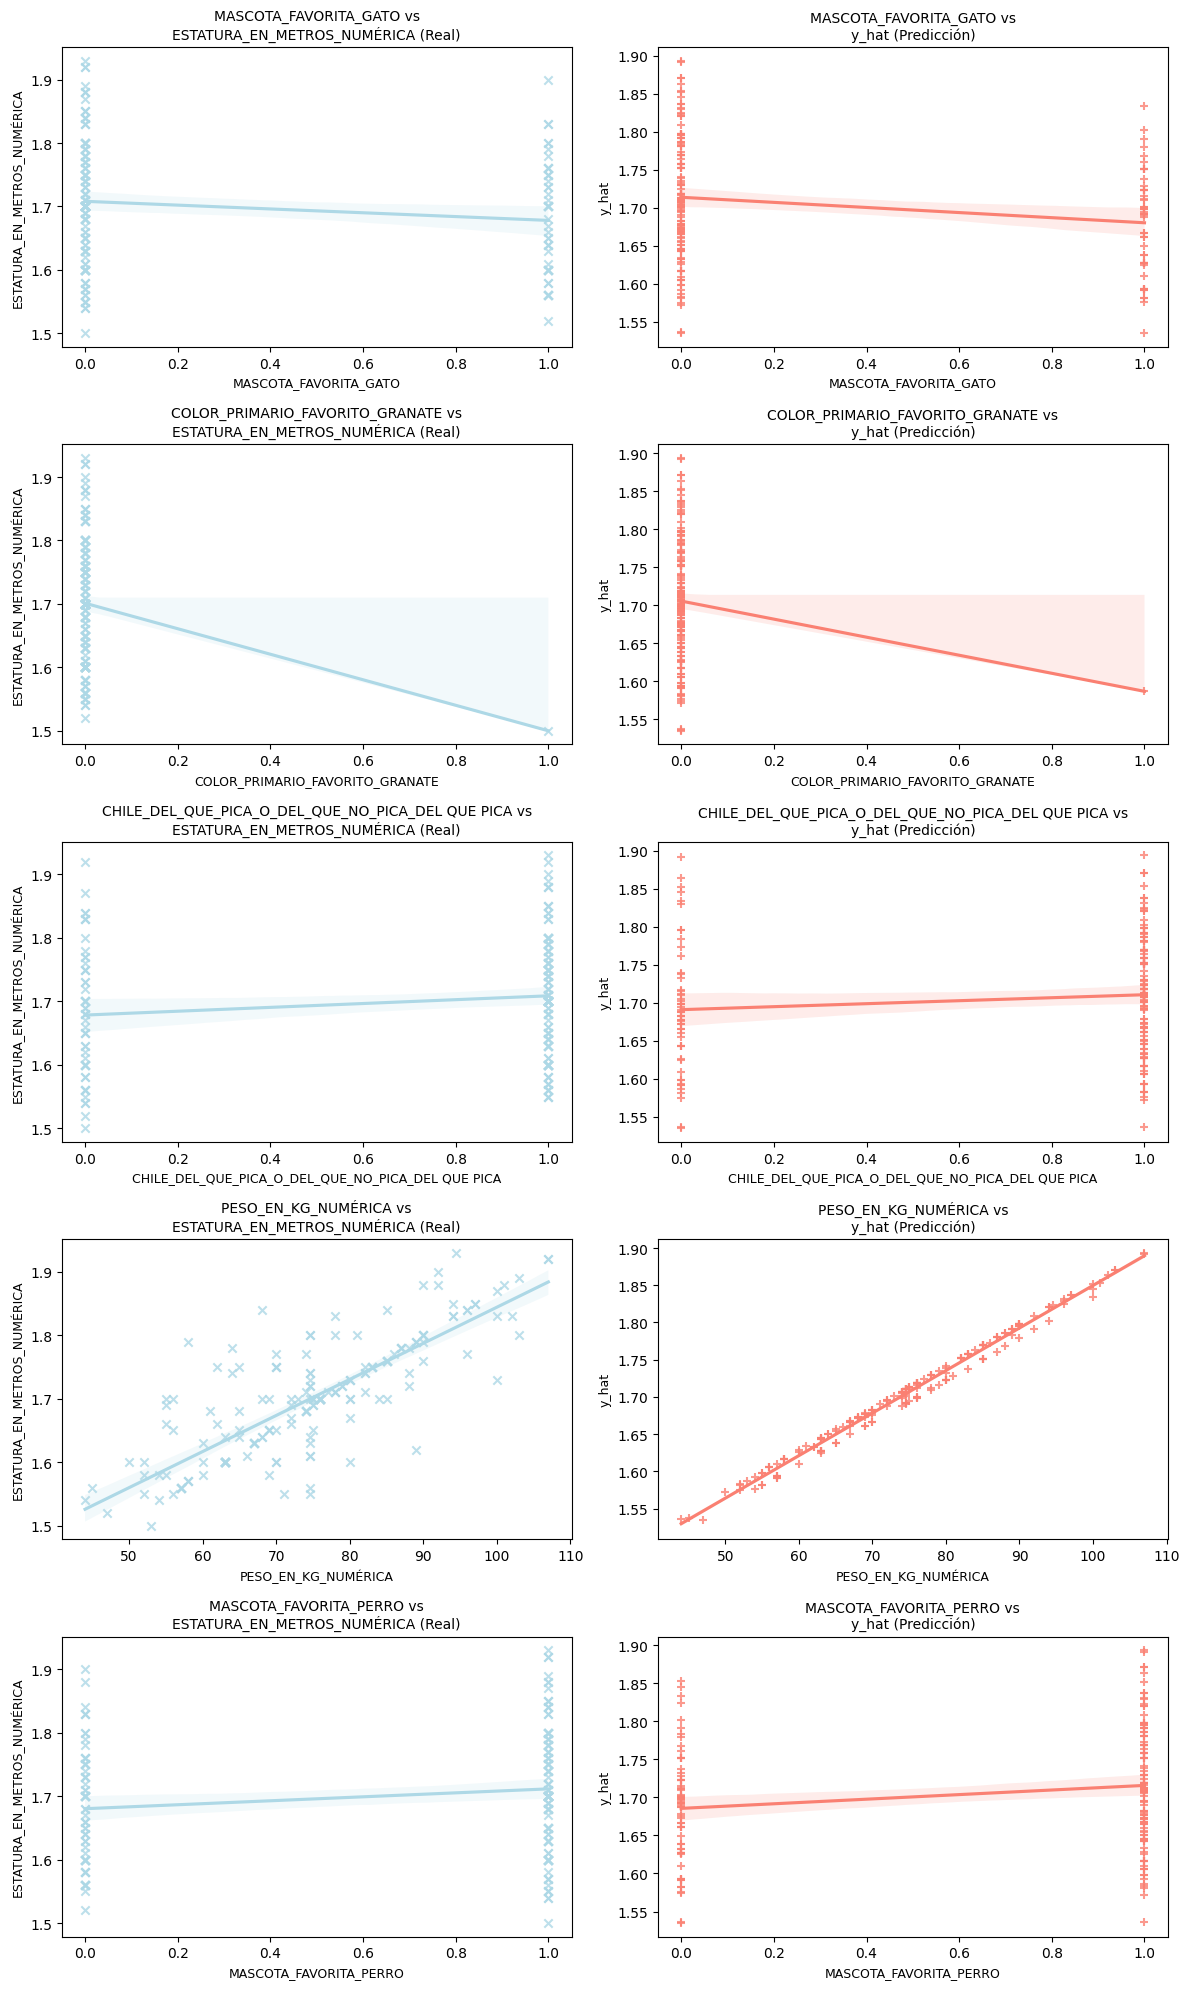

In [104]:
# Preparar datos transformados
columnas_excluir = ["ESTATURA_EN_METROS_NUMÉRICA", "MARCA_TEMPORAL"]
datos_transformados = datos_limpios.drop(columns=columnas_excluir)
datos_transformados = pd.get_dummies(datos_transformados, drop_first=True)

# Crear DataFrame combinado
df_plot = pd.concat([
    datos_limpios[["ESTATURA_EN_METROS_NUMÉRICA", "y_hat"]], 
    datos_transformados[X_train.columns]
], axis=1)

# Obtener las variables de df_res (las que están en el modelo)
features_sorted = df_res.sort_values(by="weight")['feature'].tolist()

# Crear gráficos para cada variable
n_features = len(features_sorted)
fig, axes = plt.subplots(n_features, 2, figsize=(12, 4*n_features))

for i, feature in enumerate(features_sorted):
    # Gráfico 1: Variable vs Target real
    sns.regplot(x=feature, y=target, data=df_plot, marker='x', 
                color='lightblue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} vs\n{target} (Real)', fontsize=10)
    axes[i, 0].set_xlabel(feature, fontsize=9)
    axes[i, 0].set_ylabel(target, fontsize=9)
    
    # Gráfico 2: Variable vs Predicción
    sns.regplot(x=feature, y='y_hat', data=df_plot, marker='+', 
                color='salmon', ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} vs\ny_hat (Predicción)', fontsize=10)
    axes[i, 1].set_xlabel(feature, fontsize=9)
    axes[i, 1].set_ylabel('y_hat', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Regresion logistica

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

In [106]:
### 3.2 Preparación de datos

# Definir la variable objetivo (y) - clasificación binaria
y_class = datos_limpios["TEAM_FRÍO_O_TEAM_CALOR"]

# Verificar las clases únicas
print(f"Clases únicas: {y_class.unique()}")
print(f"Distribución de clases:\n{y_class.value_counts()}")

# Definir las variables predictoras (X)
columnas_excluir = ["TEAM_FRÍO_O_TEAM_CALOR", "MARCA_TEMPORAL", "y_hat"]
X_class = datos_limpios.drop(columns=columnas_excluir)

# Convertir variables categóricas a numéricas (one-hot encoding)
X_class = pd.get_dummies(X_class, drop_first=True)

print(f"\nShape de X: {X_class.shape}")
print(f"Shape de y: {y_class.shape}")

Clases únicas: ['TEAM FRÍO' 'TEAM CALOR']
Distribución de clases:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     166
TEAM CALOR     28
Name: count, dtype: int64

Shape de X: (194, 45)
Shape de y: (194,)


In [107]:
### 3.3 Selección de variables

# Seleccionar las mejores variables para clasificación
kb_class = SelectKBest(k="all", score_func=chi2)
kb_class.fit(X_class, y_class)

df_scores_class = pd.DataFrame(
    data=zip(X_class.columns, kb_class.scores_), 
    columns=["feature", "score"]
).set_index("feature").sort_values(by="score", ascending=False)

# Seleccionar las top N variables
n_features_class = 20
ls_best_class = df_scores_class.head(n_features_class).index.tolist()

print(f"Mejores {n_features_class} variables:")
print(ls_best_class)

Mejores 20 variables:
['NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO', 'NÚMERO_DE_TATUAJES_NUMÉRICA', 'COLOR_PRIMARIO_FAVORITO_CIAN', 'COLOR_PRIMARIO_FAVORITO_ORO ROSA', 'COLOR_PRIMARIO_FAVORITO_NARANJA', 'MASCOTA_FAVORITA_PERRO Y GATO', 'MASCOTA_FAVORITA_DALMATA', 'COLOR_PRIMARIO_FAVORITO_NEGRO', 'PESO_EN_KG_NUMÉRICA', 'DÍA_O_NOCHE_NOCHE', 'COLOR_PRIMARIO_FAVORITO_AZUL', 'COLOR_PRIMARIO_FAVORITO_MORADO', 'EDAD_EN_AÑOS_NUMÉRICA', 'COLOR_PRIMARIO_FAVORITO_VERDE', 'NÚMERO_DE_HERMANOS_NUMÉRICA', 'MASCOTA_FAVORITA_OTROS', 'MASCOTA_FAVORITA_GATO', 'MASCOTA_FAVORITA_PEROO', 'COLOR_PRIMARIO_FAVORITO_ROSA', 'MASCOTA_FAVORITA_PERRO']


In [108]:
# Visualizar scores de features
fig = px.bar(
    df_scores_class.reset_index().head(20).rename(columns={"index": "feature"}), 
    x="feature", 
    y="score", 
    title="Feature Scores para Clasificación"
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [109]:
### 3.4 División Train/Test

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class[ls_best_class], 
    y_class, 
    test_size=0.3, 
)

print("X_train_class:", X_train_class.shape)
print("X_test_class:", X_test_class.shape)
print("y_train_class:", y_train_class.shape)
print("y_test_class:", y_test_class.shape)

X_train_class: (135, 20)
X_test_class: (59, 20)
y_train_class: (135,)
y_test_class: (59,)


In [110]:
# Insertar ANTES de entrenar el modelo (después de 3.4)

### 3.4.1 Análisis de desbalance de clases

print("Distribución de clases en TRAIN:")
print(y_train_class.value_counts())
print("\nPorcentajes:")
print(y_train_class.value_counts(normalize=True) * 100)

print("\nDistribución de clases en TEST:")
print(y_test_class.value_counts())
print("\nPorcentajes:")
print(y_test_class.value_counts(normalize=True) * 100)

Distribución de clases en TRAIN:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     117
TEAM CALOR     18
Name: count, dtype: int64

Porcentajes:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     86.666667
TEAM CALOR    13.333333
Name: proportion, dtype: float64

Distribución de clases en TEST:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     49
TEAM CALOR    10
Name: count, dtype: int64

Porcentajes:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     83.050847
TEAM CALOR    16.949153
Name: proportion, dtype: float64


In [111]:
### 3.5 Entrenamiento del modelo (VERSIÓN MEJORADA)

# Opción 1: Usar class_weight='balanced'
logreg = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    class_weight='balanced'  # <-- ESTO ES CLAVE para desbalance
)
logreg.fit(X_train_class, y_train_class)

# Score en entrenamiento
train_score = logreg.score(X_train_class, y_train_class)
print(f"Accuracy en entrenamiento: {train_score:.4f}")

# Verificar predicciones en entrenamiento
y_train_pred = logreg.predict(X_train_class)
print("\nClases predichas en TRAIN:")
print(pd.Series(y_train_pred).value_counts())

Accuracy en entrenamiento: 0.7926

Clases predichas en TRAIN:
TEAM FRÍO     91
TEAM CALOR    44
Name: count, dtype: int64


In [112]:
### 3.6 Cross-validation

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    estimator=logreg, 
    X=X_train_class, 
    y=y_train_class, 
    cv=5, 
    scoring="accuracy"
)


print(f"CV Scores: {cv_scores}")
print(f"CV Mean: {cv_scores.mean():.4f}")
print(f"CV Std: {cv_scores.std():.4f}")

CV Scores: [0.81481481 0.66666667 0.66666667 0.66666667 0.66666667]
CV Mean: 0.6963
CV Std: 0.0593


In [113]:
### 3.7 Validación en test

test_score = logreg.score(X_test_class, y_test_class)
print(f"Accuracy en test: {test_score:.4f}")

Accuracy en test: 0.5424


In [114]:
### 3.8 Predicciones

y_pred_class = logreg.predict(X_test_class)
y_pred_proba = logreg.predict_proba(X_test_class)[:, 1]  # Probabilidad clase positiva

# Comparar predicciones
df_predictions = pd.DataFrame({
    'Real': y_test_class,
    'Predicción': y_pred_class,
    'Probabilidad': y_pred_proba
})
df_predictions.sample(10)

,Real,Predicción,Probabilidad
201,TEAM FRÍO,TEAM CALOR,0.212661
50,TEAM FRÍO,TEAM FRÍO,0.510471
131,TEAM CALOR,TEAM FRÍO,0.633334
123,TEAM FRÍO,TEAM FRÍO,0.535585
13,TEAM FRÍO,TEAM FRÍO,0.658422
32,TEAM FRÍO,TEAM CALOR,0.415942
35,TEAM FRÍO,TEAM FRÍO,0.658422
60,TEAM FRÍO,TEAM CALOR,0.423082
94,TEAM FRÍO,TEAM CALOR,0.379106
3,TEAM FRÍO,TEAM FRÍO,0.651657


In [115]:
### 3.9 Métricas de performance

accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, pos_label='TEAM CALOR')
recall = recall_score(y_test_class, y_pred_class, pos_label='TEAM CALOR')
f1 = f1_score(y_test_class, y_pred_class, pos_label='TEAM CALOR')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Accuracy:  0.5424
Precision: 0.1600
Recall:    0.4000
F1-Score:  0.2286


In [116]:
# Classification Report completo
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test_class, y_pred_class))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

  TEAM CALOR       0.16      0.40      0.23        10
   TEAM FRÍO       0.82      0.57      0.67        49

    accuracy                           0.54        59
   macro avg       0.49      0.49      0.45        59
weighted avg       0.71      0.54      0.60        59



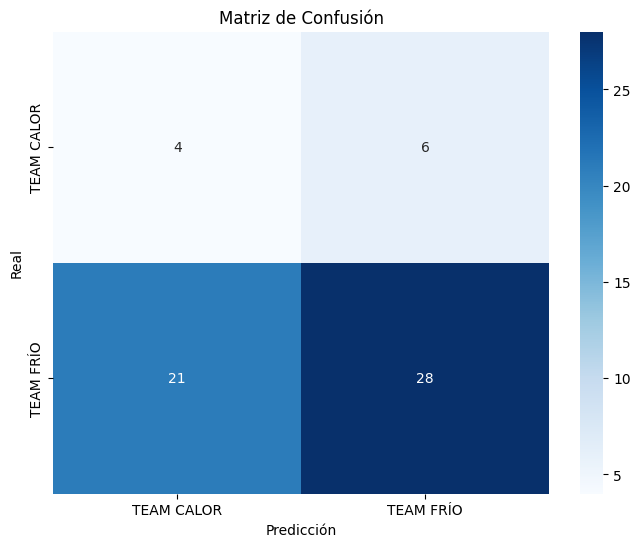

In [117]:
### 3.10 Matriz de Confusión

cm = confusion_matrix(y_test_class, y_pred_class)

# Visualización con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=logreg.classes_, 
            yticklabels=logreg.classes_)
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

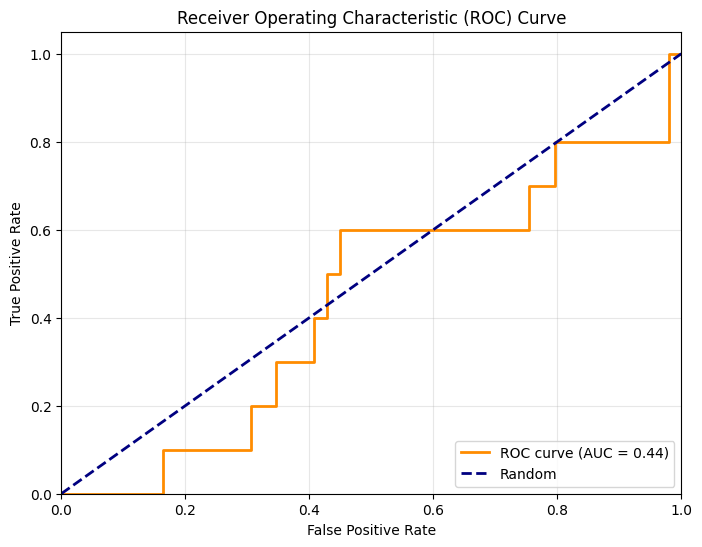

AUC-ROC: 0.4388


In [118]:
### 3.11 Curva ROC

fpr, tpr, thresholds = roc_curve(
    (y_test_class == 'TEAM CALOR').astype(int), 
    y_pred_proba
)
roc_auc = roc_auc_score(
    (y_test_class == 'TEAM CALOR').astype(int), 
    y_pred_proba
)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")

In [119]:
### 3.12 Interpretación de coeficientes

df_coef = pd.DataFrame({
    'feature': X_train_class.columns,
    'coefficient': logreg.coef_[0]
}).sort_values(by='coefficient', ascending=False)

print(df_coef)

                                              feature  coefficient
9                                   DÍA_O_NOCHE_NOCHE     0.781386
1                         NÚMERO_DE_TATUAJES_NUMÉRICA     0.713083
10                       COLOR_PRIMARIO_FAVORITO_AZUL     0.577756
17                             MASCOTA_FAVORITA_PEROO     0.278748
15                             MASCOTA_FAVORITA_OTROS     0.227694
18                       COLOR_PRIMARIO_FAVORITO_ROSA     0.216718
8                                 PESO_EN_KG_NUMÉRICA     0.053482
0   NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO     0.034247
13                      COLOR_PRIMARIO_FAVORITO_VERDE     0.006612
3                    COLOR_PRIMARIO_FAVORITO_ORO ROSA     0.000000
4                     COLOR_PRIMARIO_FAVORITO_NARANJA     0.000000
12                              EDAD_EN_AÑOS_NUMÉRICA    -0.027917
16                              MASCOTA_FAVORITA_GATO    -0.190745
14                        NÚMERO_DE_HERMANOS_NUMÉRICA    -0.29

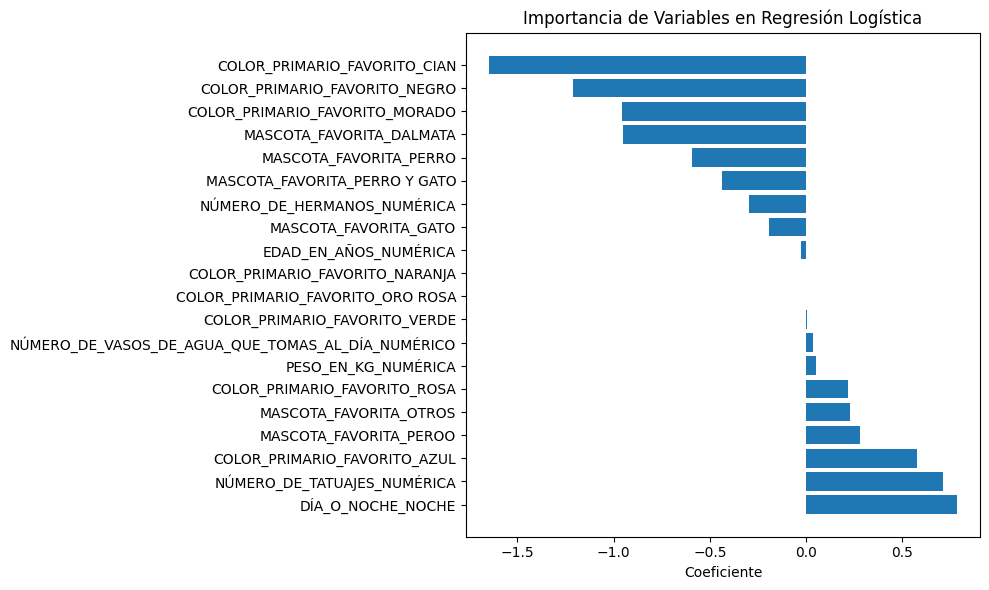

In [120]:
# Visualización de coeficientes
plt.figure(figsize=(10, 6))
plt.barh(df_coef['feature'], df_coef['coefficient'])
plt.xlabel('Coeficiente')
plt.title('Importancia de Variables en Regresión Logística')
plt.tight_layout()
plt.show()